In [534]:
import sys
!{sys.executable} -m pip install wordcloud

In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import seaborn as sns

## Visão geral do Processo
Neste trabalho vamos fazer um processo de descoberta de conhecimento em uma base de dados de redação, ou seja vamos sair de dados brutos, ou quase (!!!) para gerar algum tipo de conhecimento utili. Nosso problema é analisar um conjunto de 695 redações elaboradas por alunos do ensino médio para o o site UOL. São redações obre vinte temas as quais foram atribuidas notas por professores.
Nosso processo se dá na seguinte ordem:
<img src='https://danielteofilo.files.wordpress.com/2015/02/kdd_thumb.jpg?w=367&h=184&zoom=2' align='center' style="margin-left:20px">

Neste trabalhos estaremos empregando o framework KDD proposto por FAYYAD 1995, cuja imagem pode ser visalizada aqui:
<img src='https://danielteofilo.files.wordpress.com/2015/02/image_thumb.png?w=604&h=228&zoom=2' align='center' style="margin-left:20px">

## Seleção dos dados:
Nessa etapa forma selecionadas redações que foram extraídas do site UOL que mensamente analisa 20 redações sobre um tema previamente escolhido o dados estão disponíveis no repositório [kaggle.com](https://www.kaggle.com/danlessa/corrected-essays-with-scores-from-uol) e disponibilizam o texto integral da redação essay_text, o título d aredação essay_titel, o texto integral do descritivo do tema theme_text, o título do tema theme_title e a nota geral de cada redação total_score e notas parciais.

## Função para Criação de Histogramas

In [2]:
def histogram(s, mu, sigma,bins,tit, ax, xlabel):
    plt.figure(figsize=(6,6))
    num_bins = bins
    x = s.values
    score = s.name
    # the histogram of the data
    n, bins, patches = ax.hist(x, num_bins, density = 1, facecolor='gray', alpha=0.5, label = xlabel)

    # add a 'best fit' line
    y = scipy.stats.norm.pdf(bins, mu, sigma)
    ax.plot(bins, y, 'r--', label = 'Dist Prob')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Probabilidade')
    ax.set_title(tit+': $\mu=$'+str(round(mu,2))+', $\sigma=$'+str(round(sigma,2)))
    ax.grid(True)
    ax.legend()

    # Tweak spacing to prevent clipping of ylabel
    return

In [3]:
# Limpeza dos dados no Dataset essays
df = pd.read_csv('essays.csv', encoding ='utf_8')
df.score_1.replace(['0,0','1,0','1,5','0,5','2,0'],['0','1','1.5','0.5','2.0'], inplace=True)
df.score_1 = df.score_1.astype('float');
df.score_2.replace(['0,0','1,0','1,5','0,5','2,0'],['0','1','1.5','0.5','2.0'], inplace=True)
df.score_2 = df.score_1.astype('float')
df.score_3.replace(['0,0','1,0','1,5','0,5','2,0'],['0','1','1.5','0.5','2.0'], inplace=True)
df.score_3 = df.score_1.astype('float')
df.score_4.replace(['0,0','1,0','1,5','0,5','2,0'],['0','1','1.5','0.5','2.0'], inplace=True)
df.score_4 = df.score_1.astype('float')
df.score_5.replace(['0,0','1,0','1,5','0,5','2,0'],['0','1','1.5','0.5','2.0'], inplace=True)
df.score_5 = df.score_1.astype('float')
df1 = df.dropna(axis = 0)

In [4]:
def calculos__palavras(list):
    stop_words = set(stopwords.words('portuguese'))
    tokenizer = RegexpTokenizer(r'\w+')
    text_raw = []
    text_length = []
    text_token = []
    text_token_stop = []
    for i in range(len(list)):
        t = [word.lower() for word in tokenizer.tokenize(list[i])]
        tr = [word.lower() for word in list[i]]
        ts = []
        for w in t:
            if w not in stop_words:ts.append(w)
        text_token_stop.append(ts)
        for w in tr:
            if w not in stop_words:text_raw.append(w)
        l = len(t)
        text_length.append(l)
        text_token.append(t)
    return  text_length, text_token, text_token_stop

In [5]:
text_length, text_token, text_token_stop = calculos__palavras(df1.essay_text.values.tolist())

In [6]:
theme_stop = []
for i in range(len(df1.theme_text.values)):
    stop_words = set(stopwords.words('portuguese'))
    tokenizer = RegexpTokenizer(r'\w+')
    t = [word.lower() for word in tokenizer.tokenize(df1.theme_text.iloc[i])]
    ts = []
    for w in t:
        if w not in stop_words:ts.append(w)
    theme_stop.append(ts)

In [7]:
from nltk.tokenize import sent_tokenize
sent_quant = []
for i in range(len(df1.essay_text.values)):
    t = sent_tokenize(df.essay_text.iloc[i])
    l = len(t)
    sent_quant.append(l)

In [8]:
text_length = pd.Series(text_length)
sent_quant = pd.Series(sent_quant)
text_token_stop = pd.Series(text_token_stop)
theme_stop = pd.Series(theme_stop)

In [9]:
df1.loc[:,'text_length'] = text_length.values
df1.loc[:,'sent_quant'] = sent_quant.values
df1.loc[:,'text_token_stop'] = text_token_stop.values
df1.loc[:,'theme_stop'] = theme_stop.values

C:\Users\domin\Anaconda3\envs\Python3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\domin\Anaconda3\envs\Python3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
quantl = pd.DataFrame([text_length,sent_quant]).T
quantl.columns=['text_length','sent_quant']

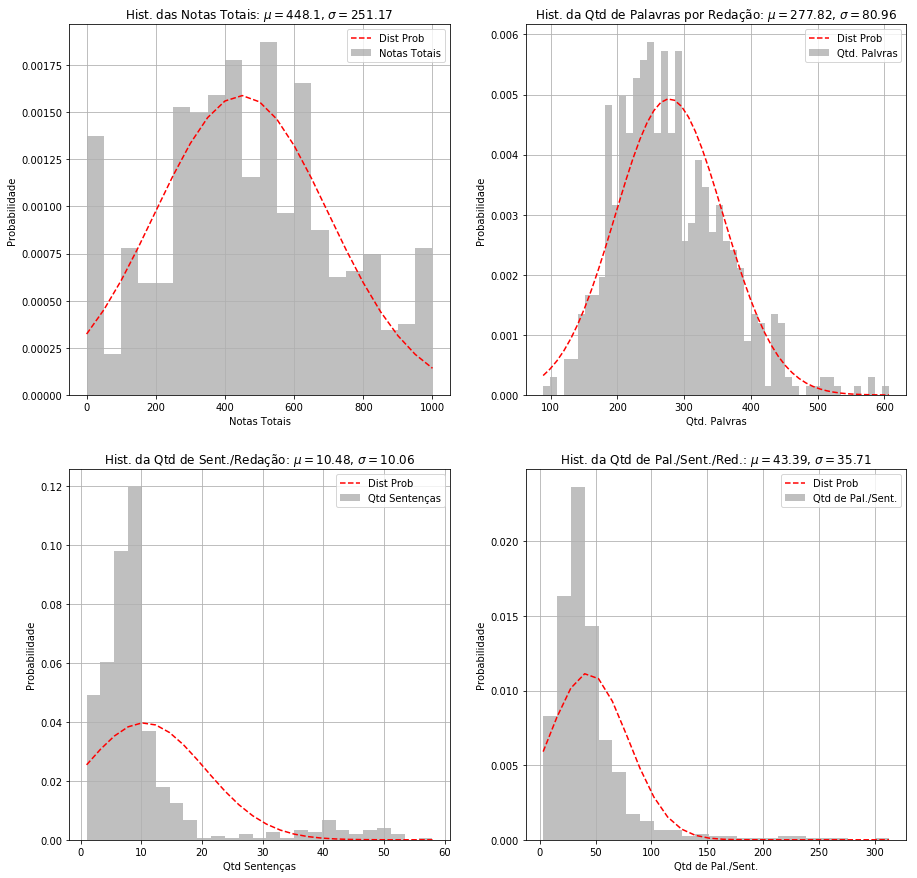

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

In [11]:
fig, axs = plt.subplots(2, 2, figsize =(15,15))
histogram(df1.total_score, df1.total_score.mean(),df1.total_score.std(),20,'Hist. das Notas Totais',axs.flat[0],'Notas Totais');
histogram(text_length,text_length.mean(),text_length.std(),50,'Hist. da Qtd de Palavras por Redação',axs.flat[1], 'Qtd. Palvras');
histogram(sent_quant,sent_quant.mean(),sent_quant.std(),25,'Hist. da Qtd de Sent./Redação',axs.flat[2], 'Qtd Sentenças');
histogram(text_length/sent_quant,(text_length/sent_quant).mean(),(text_length/sent_quant).std(),25,'Hist. da Qtd de Pal./Sent./Red.',axs.flat[3], 'Qtd de Pal./Sent.');


In [12]:
temas = df.groupby(['theme_title'])['total_score'].mean().sort_values(ascending=False).reset_index()

In [13]:
word_token_stop = []
for text in text_token_stop:
    for word in text:
        word_token_stop.append(word)

In [14]:
fdist = nltk.FreqDist(word_token_stop)

In [15]:
def plot_freqdist_freq(fd,
                       max_num=None,
                       cumulative=False,
                       title='Frequência de Palavras',
                       linewidth=2):
    """
    As of NLTK version 3.2.1, FreqDist.plot() plots the counts 
    and has no kwarg for normalising to frequency. 
    Work this around here.
    
    INPUT:
        - the FreqDist object
        - max_num: if specified, only plot up to this number of items 
          (they are already sorted descending by the FreqDist)
        - cumulative: bool (defaults to False)
        - title: the title to give the plot
        - linewidth: the width of line to use (defaults to 2)
    OUTPUT: plot the freq and return None.
    """
    plt.figure(figsize = (15,10))
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('Palavras')
    plt.ylabel('Frequência')
    tmp = fd.copy()
    norm = fd.N()
    #for key in tmp.keys():
        #tmp[key] = float(fd[key]) / norm

    if max_num:
        tmp.plot(max_num, cumulative=cumulative,
                 title=title, linewidth=linewidth)
        
    else:
        tmp.plot(cumulative=cumulative, 
                 title=title, 
                 linewidth=linewidth)

    return

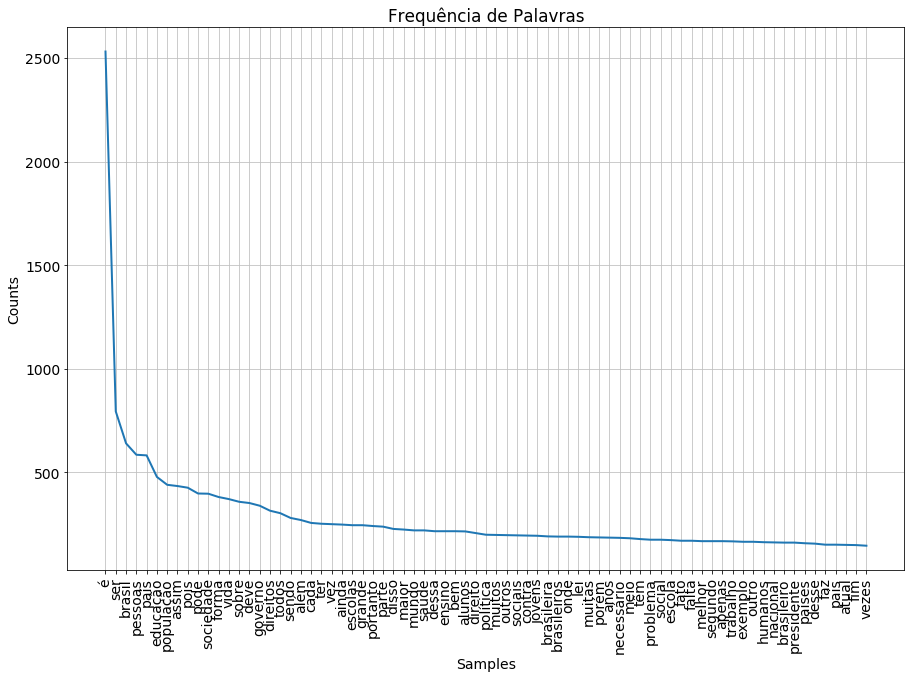

In [16]:
plot_freqdist_freq(fdist,75)

# Tf-idf e semelhança de documento

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">
Aqui, defino os parâmetros do vetorizador de frequência inversa à frequência do documento (tf-idf) e converto a lista * synopses * em uma matriz tf-idf.

Para obter uma matriz Tf-idf, conte primeiro as ocorrências de palavras por documento. Isso é transformado em uma matriz de termo de documento (dtm). Isso também é chamado de termo matriz de frequência. Um exemplo de um dtm está aqui à direita.

Em seguida, aplique o termo ponderação inversa à frequência do documento: as palavras que ocorrem com frequência em um documento, mas não no corpus, recebem uma ponderação mais alta, pois se supõe que essas palavras contêm mais significado em relação ao documento.

Algumas coisas a serem observadas sobre os parâmetros que eu defino abaixo:

<ul>
<li> max_df: esta é a frequência máxima nos documentos que um determinado recurso pode ter que ser usado na matriz tfi-idf. Se o termo estiver em mais de 80% dos documentos, provavelmente será pouco significativo (no contexto das sinopses do filme)
<li> min_idf: pode ser um número inteiro (por exemplo, 5) e o termo deve estar em pelo menos 5 dos documentos a serem considerados. Aqui eu passo 0.2; o termo deve estar em pelo menos 20% do documento. Descobri que, se permitisse um min_df menor, acabava baseando o agrupamento em nomes - por exemplo, "Michael" ou "Tom" são nomes encontrados em vários filmes e as sinopses os usam com frequência, mas os nomes não têm significado real .
<li> ngram_range: isso significa apenas que vou olhar para unigramas, bigrams e trigramas. Veja [n-gramas] (http://en.wikipedia.org/wiki/N-gram)
</ul>

In [17]:
def lower_stop(list):
    text_raw = []
    for t in list:
        text_raw.append(t.lower())
    stoplist = stopwords.words('portuguese')
    stop_text_raw = []
    for i in range(len(text_raw)):
        cleanwordlist = [word for word in text_raw[i].split() if word not in stoplist];
        cleanWordtext = ' ';
        for w in cleanwordlist:
            cleanWordtext += w + ' '
        stop_text_raw.append(cleanWordtext)
    return text_raw, stop_text_raw

In [18]:
list = df1.essay_text
text_raw, stop_text_raw = lower_stop(list)

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Matriz de Contagem e Criação da matriz Tf-idf (Matriz de Termos do Documento)
cv=CountVectorizer(stop_words = set(stopwords.words('portuguese')))
word_count_vector=cv.fit_transform(stop_text_raw)
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(word_count_vector)

In [20]:
tf_idf_vector.shape

(641, 14582)

## Visualização dos vetores de frequenciacia de termos por documento

In [21]:
# Lista de atributos extraídos
feature_names = cv.get_feature_names()
 
#Vetor tfidf do primeiro documento
first_document_vector=tf_idf_vector[0]
 
#Visualização dos Escores dos termos para o primeiro documento
sc = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
sc.sort_values(by=["tfidf"],ascending=False)

,tfidf
socioeducativo,0.274848
educacionais,0.193064
superior,0.154281
disso,0.142506
alicerce,0.137424
corrompido,0.137424
obscuridade,0.137424
fomentação,0.137424
demasiado,0.137424
emancipação,0.129195


## Usando o TfidfVectorizer

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
# settings that you use for count vectorizer will go here
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
 
# just send in all your docs here
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(stop_text_raw)

In [23]:
terms = tfidf_vectorizer.get_feature_names()
terms = pd.DataFrame(terms)

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_vectorizer_vectors)

In [44]:
tfidf_vectorizer_vectors.shape

(641, 14683)

In [45]:
len(terms)

14683

## K-Means

Agora para a parte divertida. Usando a matriz tf-idf, você pode executar vários algoritmos de clustering para entender melhor a estrutura oculta nas sinopses. Eu primeiro escolhi k-means. K-significa inicializa com um número predeterminado de clusters (eu escolhi 5). Cada observação é atribuída a um cluster (atribuição de cluster) para minimizar a soma dos quadrados dentro do cluster. Em seguida, a média das observações em cluster é calculada e usada como o novo centróide do cluster. Em seguida, as observações são reatribuídas para clusters e centróides recalculados em um processo iterativo até que o algoritmo alcance convergência.

Descobri que foram necessárias várias execuções para o algoritmo convergir para um ótimo global, pois o k-means é suscetível de atingir o ótimo local.

In [46]:
from sklearn.cluster import KMeans
num_clusters = 20
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_vectorizer_vectors)

Wall time: 11.2 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [47]:
clusters = km.labels_.tolist()

In [48]:
df1.loc[:,'cluster'] = clusters

C:\Users\domin\Anaconda3\envs\Python3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\domin\Anaconda3\envs\Python3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [49]:
for tema in df1['theme_title'].unique().tolist():
    print(tema);
    print(df1[df1['theme_title']==tema]['cluster'].value_counts()/len(df1[df1['theme_title']==tema]['cluster']));

Universidade em crise: quem paga a conta?  
0     0.85
16    0.05
12    0.05
6     0.05
Name: cluster, dtype: float64
O que é mais importante para vencer na vida?  
12    0.90
4     0.05
2     0.05
Name: cluster, dtype: float64
Os ursos polares da Rússia e um dilema ecológico  
19    0.95
13    0.05
Name: cluster, dtype: float64
Cantar ou não cantar o hino nacional? Eis a questão...  
3     0.75
11    0.15
16    0.05
12    0.05
Name: cluster, dtype: float64
Posse de armas: mais segurança ou mais perigo?  
1     0.90
13    0.05
3     0.05
Name: cluster, dtype: float64
O Brasil e os imigrantes no mundo contemporâneo  
13    0.85
12    0.10
4     0.05
Name: cluster, dtype: float64
Epidemia alimentar: sobrepeso e obesidade  
7     0.40
6     0.40
12    0.10
16    0.05
3     0.05
Name: cluster, dtype: float64
A onda conservadora e o Brasil nos próximos anos  
15    0.35
16    0.25
13    0.20
4     0.10
12    0.05
3     0.05
Name: cluster, dtype: float64
Patrimônio histórico e cultural brasi

In [50]:
table = pd.pivot_table(df1, index=['theme_title'],columns=['cluster'], aggfunc='count')['Unnamed: 0'].fillna(0)/20

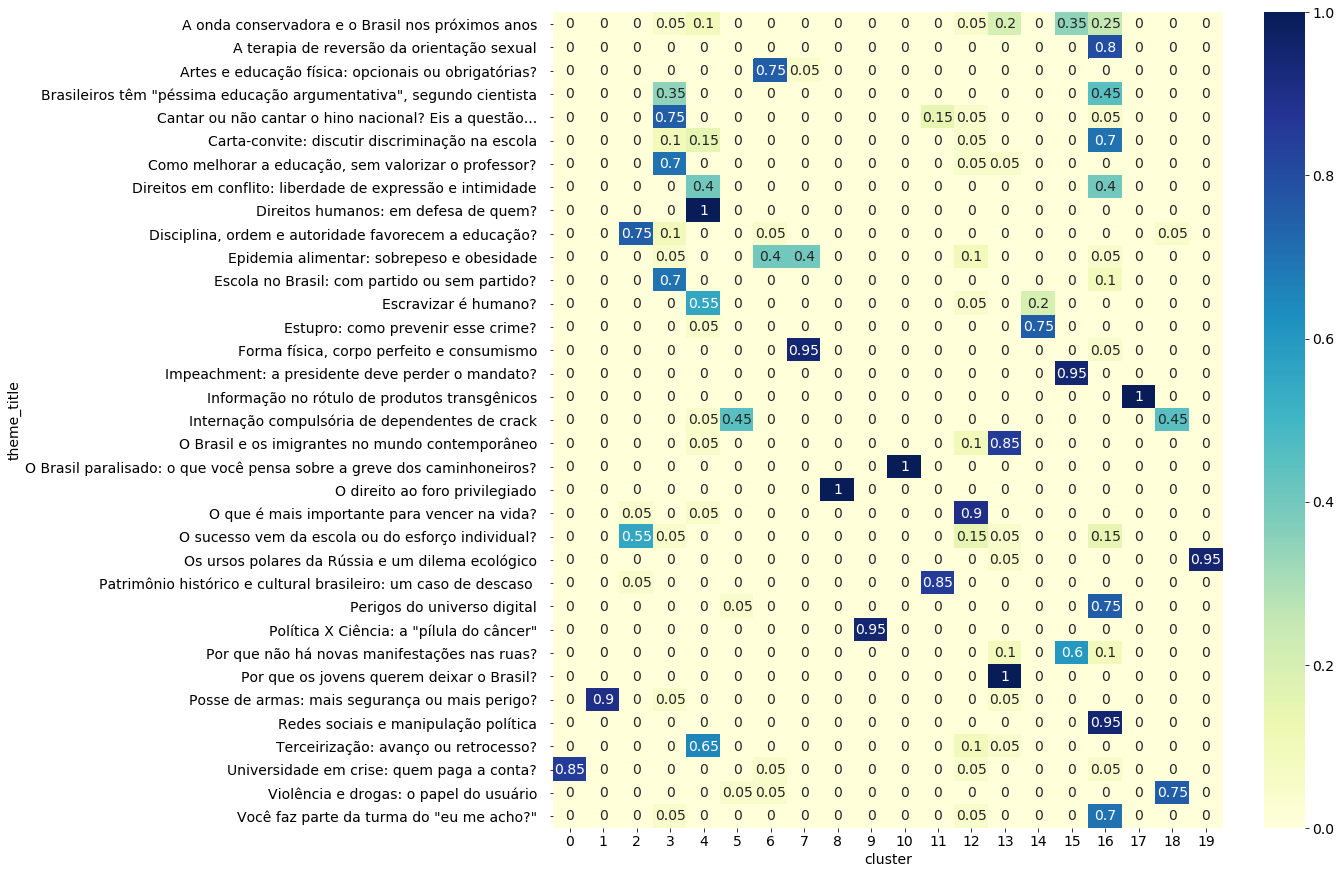

In [51]:
import seaborn as sns
plt.figure(figsize=(15,15))
ax = sns.heatmap(table, cmap="YlGnBu", annot=True)

In [ ]:
ax1 = sns.heatmap(dist, cmap="YlGnBu", annot=True)

In [52]:
# Função para gerar Texto sem stop word e stemmed

def text_stemmer(stop_text_raw):
    stemmer = SnowballStemmer('portuguese')
    text_token_stop = []
    text_token_stem = []

    for i in range(len(stop_text_raw)):
        text = tokenizer.tokenize(stop_text_raw[i])
        text_stemmed = [stemmer.stem(x) for x in text]
        text_token_stop.append(text)
        text_token_stem.append(text_stemmed)
    return text_token_stop, text_token_stem

In [53]:
# Função para gerar lista de palavaras dos textos e dos textos stemmed
def word_list(text_token_stop):
    words = []
    word_stem = []
    for i in range(len(text_token_stop)):
        for w in text_token_stop[i]:
            words.append(w)
        for ws in text_token_stem[i]:
            word_stem.append(ws)
        return words, word_stem

In [54]:
# função para criação do vocabulario
def vocabulario(words, word_stem):
    vocabulario = pd.DataFrame([words,word_stem]).T;
    vocabulario.index = words;
    vocabulario.columns = ['words','word_stem']
    vocabulario.drop(['words'],axis =1, inplace = True)
    return vocabulario

In [55]:
text_token_stop, text_token_stem = text_stemmer(stop_text_raw)
words, word_stem = word_list(text_token_stop)
vocabulario = vocabulario(words, word_stem)

## Escalonamento Multidimensional

In [56]:
from sklearn.manifold import MDS

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [57]:
df1.loc[:,'X'] = xs;
df1.loc[:,'Y'] = ys;

C:\Users\domin\Anaconda3\envs\Python3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\domin\Anaconda3\envs\Python3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [58]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1];
matriz = []
line = []
for row in range(len(order_centroids[:,:10])):
    for j in range(10):
        line.append(terms.loc[order_centroids[row,j],0])
    matriz.append(line)
    line = []

In [59]:
Key_clusters = pd.DataFrame(matriz).T

In [60]:
Key_clusters.columns = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 6','Cluster 6',
                        'Cluster 7','Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'Cluster 12', 'Cluster 12',
                        'Cluster 14','Cluster 15', 'Cluster 16', 'Cluster 17', 'Cluster 18', 'Cluster 19']

In [61]:
Key_clusters.to_excel('PalavrasChaveClusters.xls')

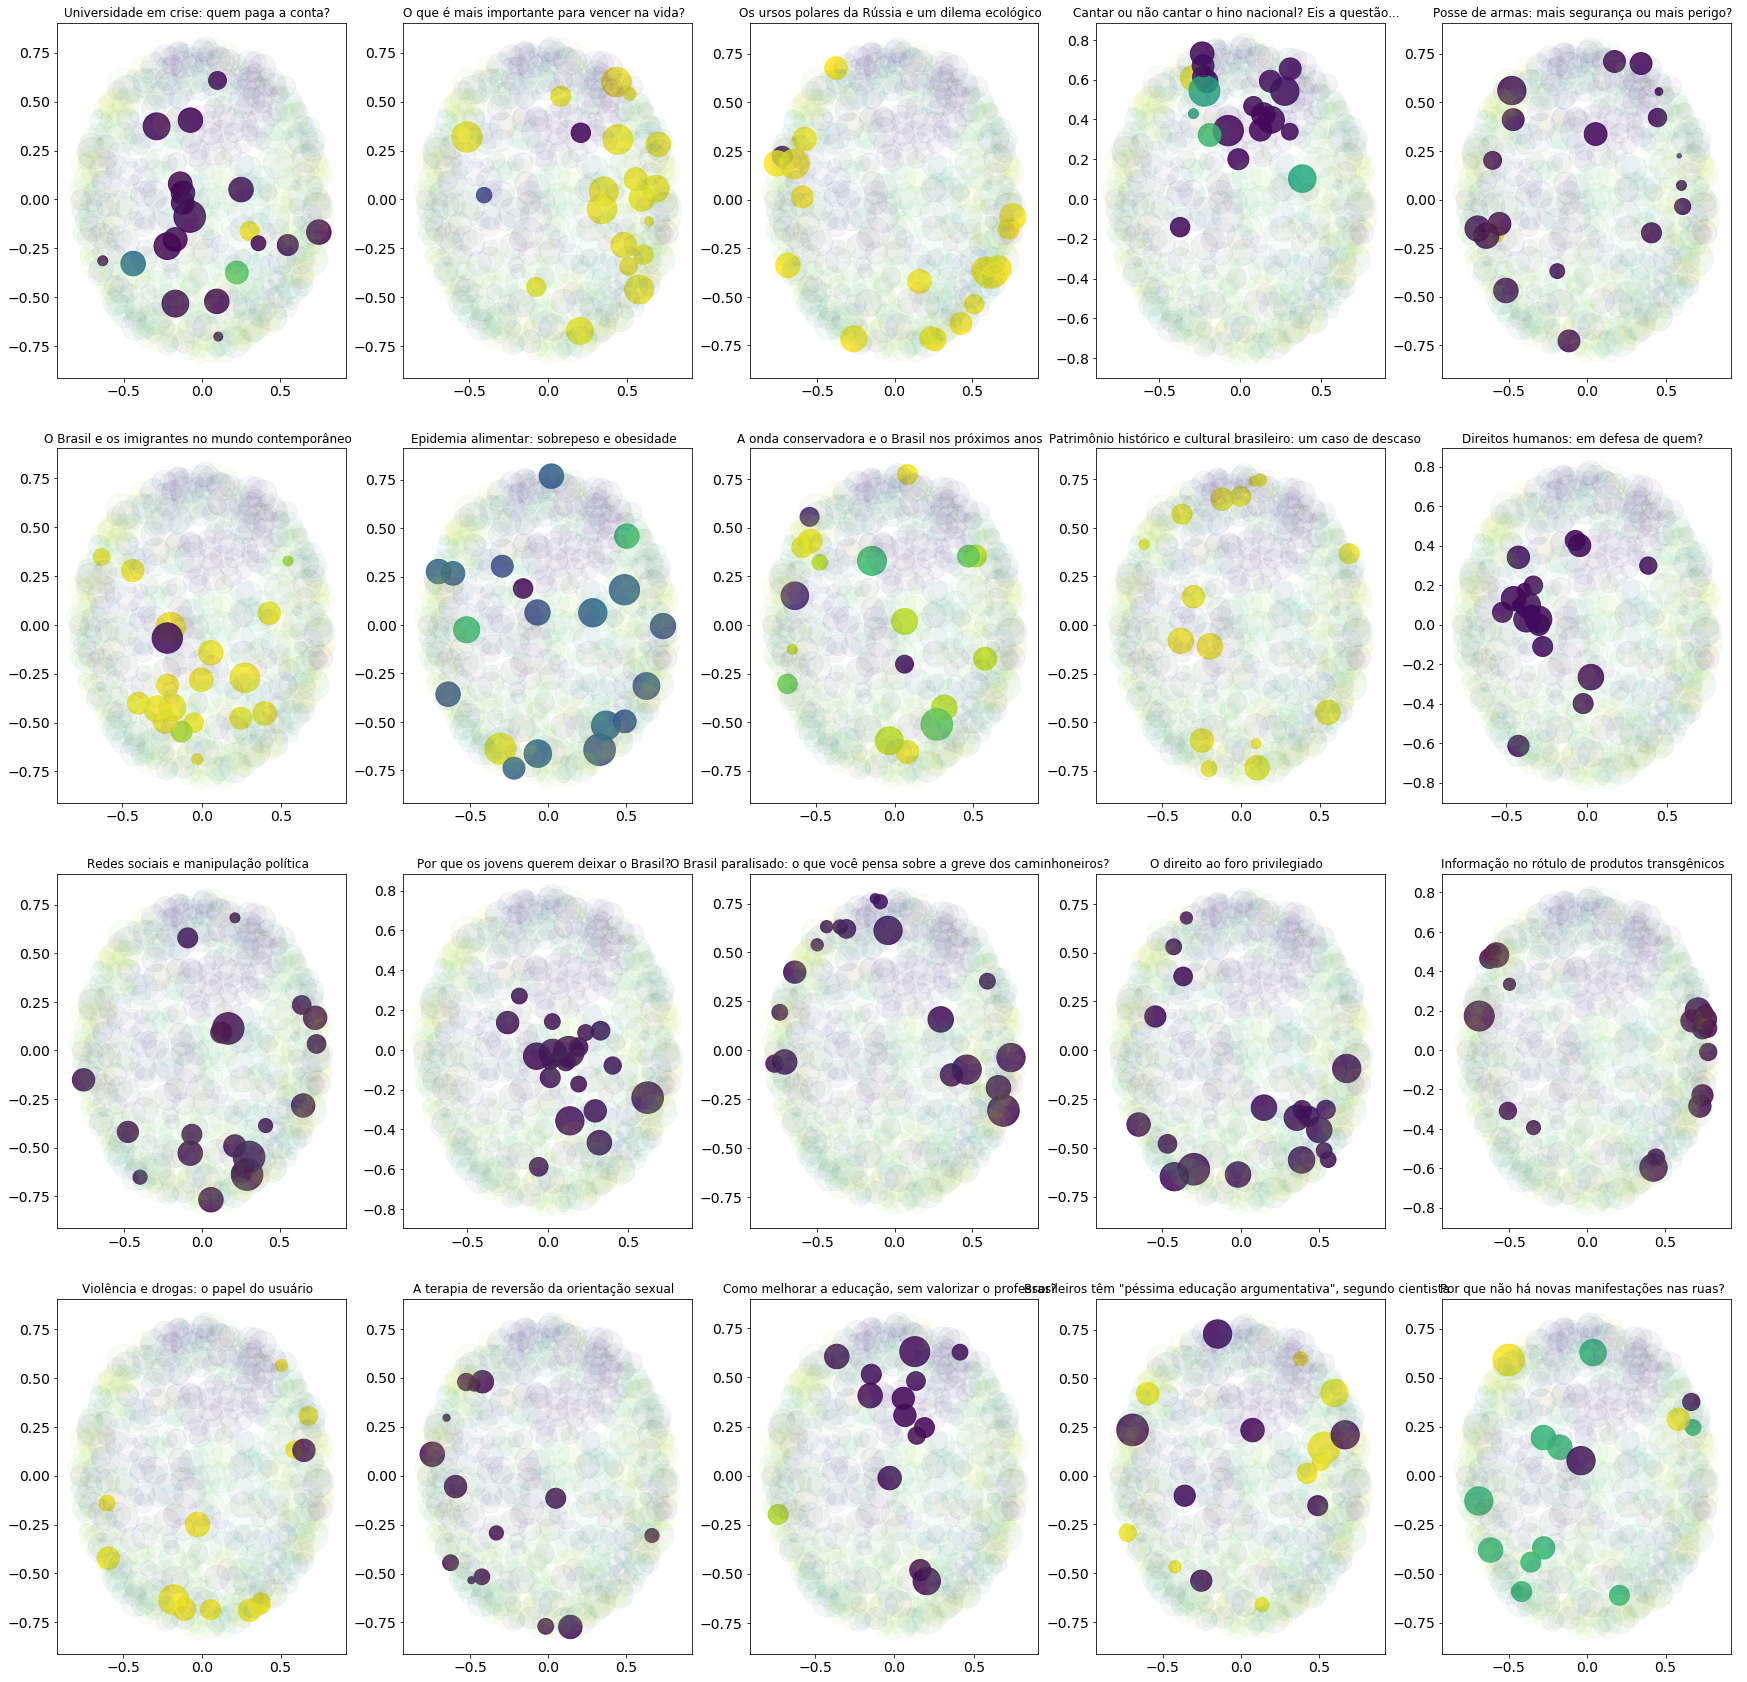

In [62]:
#plt.figure(figsize=(20,25))
fig, axs = plt.subplots(4, 5, figsize = (30,30))

i =0
temas= df1['theme_title'].unique().tolist();
for ax in axs.flat:
    #abel = [df1[df1['theme_title']==tema[i]]['cluster']]
    ax.scatter(df1[df1['theme_title']==temas[i]]['X'],df1[df1['theme_title']==temas[i]]['Y'],
                s=df1[df1['theme_title']==temas[i]]['total_score'],
                c=df1[df1['theme_title']==temas[i]]['cluster'], alpha = 0.85)
              #label = df1[df1['theme_title']==temas[i]]['cluster'].unique().tolist());
    ax.scatter(df1['X'],df1['Y'],s=df1['total_score'],c=df1['cluster'], alpha = 0.05);
    ax.set_title(temas[i], fontsize = 12)
    #ax.legend()
    i+=1



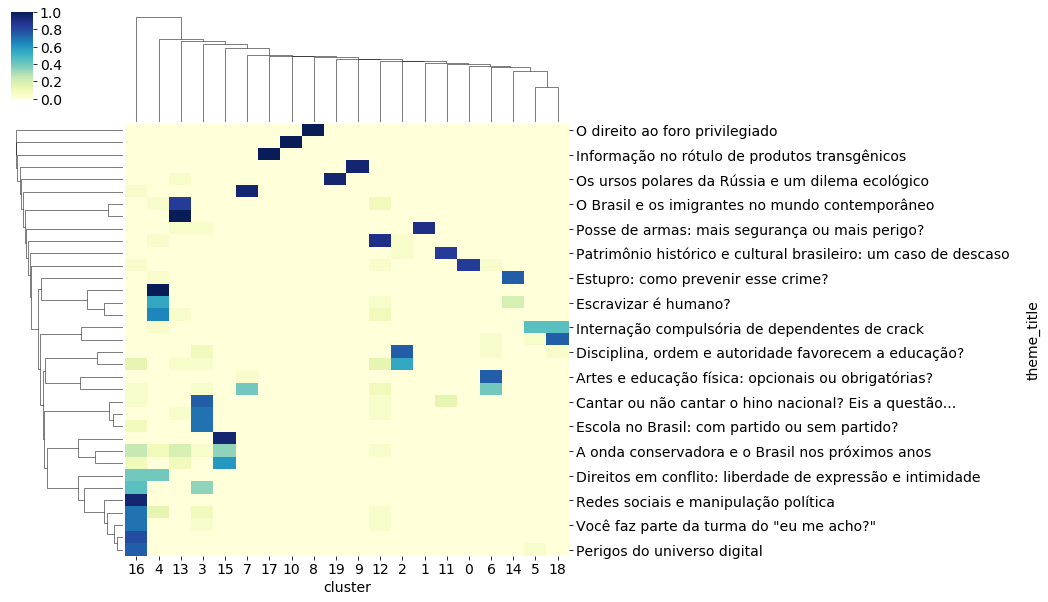

In [63]:
g = sns.clustermap(table, cmap="YlGnBu" )